In [1]:
import numpy as np
import pandas as pd

import pytraj as pt
import mdtraj as md
import seaborn as sns

%matplotlib inline
import matplotlib as mpl
mpl.rc("font", family="Arial")
import matplotlib.pyplot as plt

import pickle
import os
import sys

from glob import glob

import free_energy_clustering as FEC

## References and trajectories

In [2]:
rf0=pt.load('../1-Trajectories/0-Parm_rst/closed6_dry_rot0.rst7', 
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot0.parm7')

rf1=pt.load('../1-Trajectories/0-Parm_rst/closed6_dry_rot1.rst7', 
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot1.parm7')

rf2=pt.load('../1-Trajectories/0-Parm_rst//closed6_dry_rot2.rst7',
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot2.parm7')

rf3=pt.load('../1-Trajectories/0-Parm_rst/closed6_dry_rot3.rst7', 
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot3.parm7')

rf4=pt.load('../1-Trajectories/0-Parm_rst/closed6_dry_rot4.rst7',
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot4.parm7')

rf5=pt.load('../1-Trajectories/0-Parm_rst/closed6_dry_rot5.rst7', 
            '../1-Trajectories/0-Parm_rst/closed6_dry_rot5.parm7')

rfopen=pt.load('../1-Trajectories/0-Parm_rst/open10_dry.rst7',
               '../1-Trajectories/0-Parm_rst/open10_dry.parm7')

In [3]:
indir1 = '../1-Trajectories/2-NoEq_with_IPA'
indir2 = '../1-Trajectories/4-Adaptive_sampling_with_IPA'
topfile = '../1-Trajectories/0-Parm_rst/open10_dry.parm7'

traj_list1 = sorted(glob(indir1+'/*.nc'))
traj_list2 = sorted(glob(indir2+'/*.nc'))

traj_list=traj_list1+traj_list2
traj_list

['../1-Trajectories/2-NoEq_with_IPA/closed_ipa_dry_01.nc',
 '../1-Trajectories/2-NoEq_with_IPA/closed_ipa_dry_02.nc',
 '../1-Trajectories/2-NoEq_with_IPA/closed_ipa_dry_03.nc',
 '../1-Trajectories/2-NoEq_with_IPA/closed_ipa_dry_04.nc',
 '../1-Trajectories/2-NoEq_with_IPA/closed_ipa_dry_05.nc',
 '../1-Trajectories/2-NoEq_with_IPA/closed_ipa_dry_06.nc',
 '../1-Trajectories/2-NoEq_with_IPA/closed_ipa_dry_07.nc',
 '../1-Trajectories/2-NoEq_with_IPA/closed_ipa_dry_08.nc',
 '../1-Trajectories/2-NoEq_with_IPA/closed_ipa_dry_09.nc',
 '../1-Trajectories/2-NoEq_with_IPA/closed_ipa_dry_10.nc',
 '../1-Trajectories/2-NoEq_with_IPA/open_ipa_dry_01.nc',
 '../1-Trajectories/2-NoEq_with_IPA/open_ipa_dry_02.nc',
 '../1-Trajectories/2-NoEq_with_IPA/open_ipa_dry_03.nc',
 '../1-Trajectories/2-NoEq_with_IPA/open_ipa_dry_04.nc',
 '../1-Trajectories/2-NoEq_with_IPA/open_ipa_dry_05.nc',
 '../1-Trajectories/2-NoEq_with_IPA/open_ipa_dry_06.nc',
 '../1-Trajectories/2-NoEq_with_IPA/open_ipa_dry_07.nc',
 '../1-Traj

## GMM construction with limited dataset

First the GMM is built using uncorrelated data. We assume the data to be uncorrelated for a frame every 500 ps (dt=5)

The trajectory is therefore first loaded with a stride of 5

In [4]:
traj = pt.iterload(traj_list, topfile, stride=5)

The RMSD is then calculated. Because of the symmerty and chain IDs, 6 references are used for the closed form (simplky corresponding to a rotation of the chain IDs, and the minimum RMSD is retained

In [5]:
rmsd0=pt.rmsd(traj,ref=rf0, mask="@CA,N,C,O")
rmsd1=pt.rmsd(traj,ref=rf1, mask="@CA,N,C,O")
rmsd2=pt.rmsd(traj,ref=rf2, mask="@CA,N,C,O")
rmsd3=pt.rmsd(traj,ref=rf3, mask="@CA,N,C,O")
rmsd4=pt.rmsd(traj,ref=rf4, mask="@CA,N,C,O")
rmsd5=pt.rmsd(traj,ref=rf5, mask="@CA,N,C,O")

rmsd_closed=np.nanmin(np.array([rmsd0,rmsd1,rmsd2,rmsd3,rmsd4,rmsd5]), axis=0)

rmsd_open=pt.rmsd(traj,ref=rfopen, mask="@CA,N,C,O")

We construct a array Z with the RMSD to the closed form and to the open form for each frame of the reduced trajectory

In [6]:
Z=[]
for i in range(0,len(rmsd_open)):
    a=np.array([rmsd_closed[i],rmsd_open[i]])
    Z.append(a)
Z=np.array(Z)

In [7]:
with open('./pickled/1-With_IPA/Z_dt5.pickle', 'wb') as outf:
    pickle.dump(Z, outf)
    
# with open('./pickled/1-With_IPA/Z_dt5.pickle', 'rb') as inf:
#     Z = pickle.load(inf)

We need to find the optimum number of components for constructing the GMM so we screen for a window of 2 to 20 components.

In [9]:
fec = FEC.FreeEnergyClustering(Z, min_n_components=18, max_n_components=25, temperature=293.15,
                               x_lims=[[0.0,4.5],[0.0,4.5]],
                               n_iterations=10, n_grids=151, n_splits=1,stack_landscapes=True)
coords, FE_landscape, FE_points = fec.landscape()

*----------------Gaussian mixture model free energy estimator----------------*
   n_splits = 1
   shuffle_data = False
   n_iterations = 10
   n_grids = 151
   covergence_tol = 0.0001
   stack_landscapes = True
   x_lims (axes limits) = [[0.0, 4.5], [0.0, 4.5]]
   temperature = 293.15
   min_n_components = 18
   max_n_components = 25
   n_components_step = 1
   Using weighted data: False
*----------------------------------------------------------------------------*
Estimating density with stacked GMMs.
# Components = 18
# Components = 19
# Components = 20
# Components = 21
# Components = 22
# Components = 23
# Components = 24
# Components = 25
Removing zero-weighted models.
Model weights: [1.]
GMM list: [<free_energy_clustering.GMM.GaussianMixture object at 0x7f930c7aab90>]
# Components in models: [23]
Evaluating density in landscape
Density grid shape: [151, 151]


The optimum number of components is 23, so we build and save a GMM with that many components

In [19]:
fec = FEC.FreeEnergyClustering(Z, min_n_components=23, max_n_components=23, temperature=293.15,
                               x_lims=[[0.0,4.5],[0.0,4.5]],
                               n_iterations=10, n_grids=151, n_splits=1,stack_landscapes=False)
coords, FE_landscape, FE_points = fec.landscape()

*----------------Gaussian mixture model free energy estimator----------------*
   n_splits = 1
   shuffle_data = False
   n_iterations = 10
   n_grids = 151
   covergence_tol = 0.0001
   stack_landscapes = False
   x_lims (axes limits) = [[0.0, 4.5], [0.0, 4.5]]
   temperature = 293.15
   min_n_components = 23
   max_n_components = 23
   n_components_step = 1
   Using weighted data: False
*----------------------------------------------------------------------------*
Estimating density with GMM.
# Components = 23
Identifying final model with 23 components.
Evaluating density in landscape
Density grid shape: [151, 151]


In [17]:
with open('./pickled/1-With_IPA/coords_dt5.pickle', 'wb') as outf:
    pickle.dump(coords, outf)
with open('./pickled/1-With_IPA/FE_landscape_dt5.pickle', 'wb') as outf:
    pickle.dump(FE_landscape, outf)
with open('./pickled/1-With_IPA/FE_points_dt5.pickle', 'wb') as outf:
    pickle.dump(FE_points, outf)
    
# with open('./pickled/1-With_IPA/coords_dt5.pickle', 'rb') as inf:
#     coords = pickle.load(inf)
# with open('./pickled/1-With_IPA/FE_landscape_dt5.pickle', 'rb') as inf:
#     FE_landscape = pickle.load(inf)
# with open('./pickled/1-With_IPA/FE_points_dt5.pickle', 'rb') as inf:
#     FE_points = pickle.load(inf)

# fec.FE_points_ = np.copy(FE_landscape)
# fec.FE_landscape_ = np.copy(FE_landscape)
# fec.coords_ = coords   

We can then plot the FES

/home/el14718/Modelling/10-ALKEIG/12-Analysis_4/11-InfleCS_clustering_3/free_energy_clustering/GMM_free_energy.py:537: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("nipy_spectral"))
  my_cmap.set_over('white')


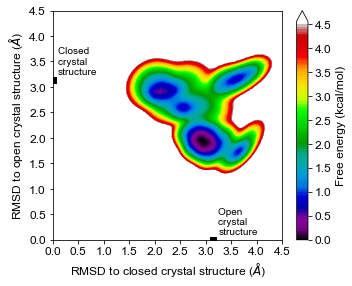

In [11]:
fec.visualize(fontsize=12, savefig=True, xlabel=r'RMSD to closed crystal structure ($\AA$)',
              ylabel=r'RMSD to open crystal structure ($\AA$)', zlabel='z', title=None,
              vmax=4.5, colormap='nipy_spectral', lim=0.1, n_contour_levels=99, show_data=False, 
              figsize= [5, 5], transition_point_size=1, core_point_size=5, core_point_edgecolor='k', 
              colormap2='spectral',clust_point_edgecolor='w', clust_point_facecolor='', 
              clust_point_size=5, clust_point_linewidth=4, clust_point_marker='s',legend=None,
              extend='max', rmsd_point_size=40, rmsd_point_fontsize=10,rmsd_point_color='k', dx=1,
              filename='./plots/1-With_IPA/1-FES_with_IPA_dt5', ax=None)

## Clustering for the limited dataset

In [12]:
labels, cluster_centers = fec.cluster(coords, FE_points,Z, assign_transition_points=True)
print("Cluster center indices: "+str(cluster_centers))

Clustering free energy landscape...
Computing Hessians of density landscape.
Point: 22801/22801
Constructing connected components.
# Graph connections: 7418.0
Clustering data points.
Cluster labels: [0. 1. 2. 3. 4. 5.]
Assigning cluster indices to non-core cluster points.
Done clustering.
Cluster center indices: [118301 135717  19819  38451 158479]


In [20]:
labels, cluster_centers = fec.cluster(coords, FE_points,Z, assign_transition_points=True)
print("Cluster center indices: "+str(cluster_centers))

Clustering free energy landscape...
Computing Hessians of density landscape.
Point: 22801/22801
Constructing connected components.
# Graph connections: 6250.0
Clustering data points.
Cluster labels: [0. 1. 2. 3. 4. 5.]
Assigning cluster indices to non-core cluster points.
Done clustering.
Cluster center indices: [145367 127541  16468 111113 162498]


In [16]:
with open('./pickled/1-With_IPA/labels_dt5.pickle', 'wb') as outf:
    pickle.dump(labels, outf)
with open('./pickled/1-With_IPA/cluster_centers_dt5.pickle', 'wb') as outf:
    pickle.dump(cluster_centers, outf)
    
# with open('./pickled/1-With_IPA/labels_dt5.pickle', 'rb') as inf:
#     labels=pickle.load(inf)
# with open('./pickled/1-With_IPA/cluster_centers_dt5.pickle', 'rb') as inf:
#     cluster_centers=pickle.load(inf)
    
# fec.labels_ = np.copy(labels)
# fec.cluster_centers_ = np.copy(cluster_centers)

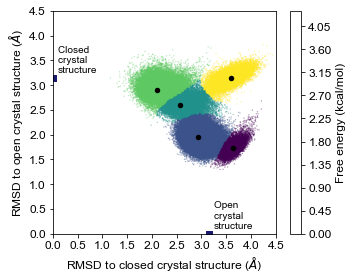

In [13]:
fec.pathways_ = None
fec.visualize(fontsize=12, savefig=True, xlabel=r'RMSD to closed crystal structure ($\AA$)',
              ylabel=r'RMSD to open crystal structure ($\AA$)', zlabel='z', title=None,
              vmax=4.25, colormap='nipy_spectral', lim=0.1, n_contour_levels=100, show_data=True, 
              figsize= [5, 5], transition_point_size=0, core_point_size=0.05, core_point_edgecolor=None, 
              colormap2='viridis',clust_point_edgecolor=None, clust_point_facecolor='k', 
              clust_point_size=30, clust_point_linewidth=0, clust_point_marker='o',legend=None,
              extend='neither', rmsd_point_size=40, rmsd_point_fontsize=10, dx=1,
              core_point_alpha=0.8, transition_point_alpha=0.0, surface_alpha=0.0,
              filename='./plots/1-With_IPA/2-Cluster_map_with_IPA_dt5.png', ax=None)

/home/el14718/Modelling/10-ALKEIG/12-Analysis_4/11-InfleCS_clustering_3/free_energy_clustering/GMM_free_energy.py:537: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("nipy_spectral"))
  my_cmap.set_over('white')


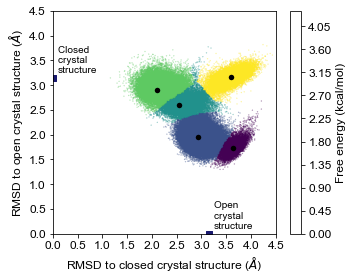

In [21]:
fec.pathways_ = None
fec.visualize(fontsize=12, savefig=True, xlabel=r'RMSD to closed crystal structure ($\AA$)',
              ylabel=r'RMSD to open crystal structure ($\AA$)', zlabel='z', title=None,
              vmax=4.25, colormap='nipy_spectral', lim=0.1, n_contour_levels=100, show_data=True, 
              figsize= [5, 5], transition_point_size=0, core_point_size=0.05, core_point_edgecolor=None, 
              colormap2='viridis',clust_point_edgecolor=None, clust_point_facecolor='k', 
              clust_point_size=30, clust_point_linewidth=0, clust_point_marker='o',legend=None,
              extend='neither', rmsd_point_size=40, rmsd_point_fontsize=10, dx=1,
              core_point_alpha=0.8, transition_point_alpha=0.0, surface_alpha=0.0,
              filename='./plots/1-With_IPA/2-Cluster_map_with_IPA_dt5.png', ax=None)

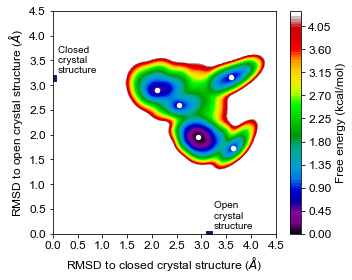

In [22]:
fec.visualize(fontsize=12, savefig=True, xlabel=r'RMSD to closed crystal structure ($\AA$)',
              ylabel=r'RMSD to open crystal structure ($\AA$)', zlabel='z', title=None,
              vmax=4.25, colormap='nipy_spectral', lim=0.1, n_contour_levels=100, show_data=True, 
              figsize= [5, 5], transition_point_size=0, core_point_size=0.0, core_point_edgecolor='k', 
              colormap2='jet',clust_point_edgecolor='k', clust_point_facecolor='w', 
              clust_point_size=30, clust_point_linewidth=0, clust_point_marker='o',legend=None,
              extend='neither', rmsd_point_size=40, rmsd_point_fontsize=10, dx=1,
              core_point_alpha=0.8, transition_point_alpha=0.0, surface_alpha=1,
              filename='./plots/1-With_IPA/3-FES_with_IPA_with_cluster_centres_dt5.png', ax=None)

In [25]:
# Computing state populations
state_populations = fec.population_states(n_sampled_points=100000)
state_populations

Sampling points from density.
Assigning cluster labels based on precomputed density model clustering.
Computing state populations.


array([0.05970965, 0.51688635, 0.        , 0.06894248, 0.23993197,
       0.11452955])

In [29]:
state_populations*100

array([ 5.97096519, 51.68863512,  0.        ,  6.89424771, 23.99319687,
       11.45295511])

([<matplotlib.axis.XTick at 0x7f92f8b47710>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

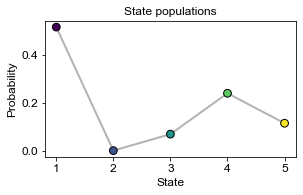

In [26]:
# Plotting the state populations

plt.figure(figsize=[4.5,2.5]);

plt.plot(np.arange(1,state_populations.shape[0]),
         state_populations[1::]/state_populations.sum(),
         linewidth=2,color=[0.7,0.7,0.7],zorder=-1)

plt.scatter(np.arange(1,state_populations.shape[0]),
            state_populations[1::]/state_populations.sum(),
            s=60,c=np.arange(1,state_populations.shape[0]),cmap='viridis',edgecolor='k')

plt.title('State populations',fontsize=12)
plt.xlabel('State',fontsize=12)
plt.ylabel('Probability',fontsize=12)
plt.xticks(np.arange(1,state_populations.shape[0]))

([<matplotlib.axis.XTick at 0x7f92f8b0d610>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

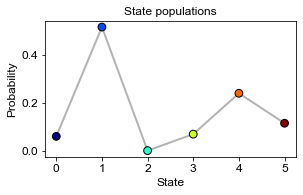

In [27]:
plt.figure(figsize=[4.5,2.5]);

plt.plot(np.arange(0,state_populations.shape[0]),
         state_populations[0::]/state_populations.sum(),
         linewidth=2,color=[0.7,0.7,0.7],zorder=-1)

plt.scatter(np.arange(0,state_populations.shape[0]),
            state_populations[0::]/state_populations.sum(),
            s=60,c=np.arange(0,state_populations.shape[0]),cmap='jet',edgecolor='k')

plt.title('State populations',fontsize=12)
plt.xlabel('State',fontsize=12)
plt.ylabel('Probability',fontsize=12)
plt.xticks(np.arange(0,state_populations.shape[0]))